<a href="https://colab.research.google.com/github/Hamid-GHub/Introduction-to-Deep-Learning-Course-Week-3-Assignment/blob/main/Introduction_to_Deep_Learning_Week_3_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Histopathologic Cancer Detection Using Convolutional Neural Network**

**Project Explanation**: This project deals with a large dataset of pathology scans of patients. Each image in the dataset can either represent cancer or not. The goal of the project is to to build a deep learning model based on this dataset. The model is expected to take an unseen image as a input and predict whether or not the image show cancer.

In [ ]:
# Importing necessary libraries and downloading the dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imread
from matplotlib.pyplot import figure
import seaborn as sns
import os,pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_path = "/content/histopathologic-cancer-detection/train"
test_path =  "/content/histopathologic-cancer-detection/test"
dataset_path = "/content/histopathologic-cancer-detection/"

In [ ]:
tf.__version__

'2.9.2'

In [ ]:
 # Downloading the dataset from kaggle and extract it
! pip install -q kaggle
from google.colab import files

##files.upload()
%cd /content

! rm -rf ~/.kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! rm -rf histopathologic-cancer-detection.zip
! kaggle competitions download -c histopathologic-cancer-detection

! rm -rf histopathologic-cancer-detection
! unzip -q histopathologic-cancer-detection.zip  -d histopathologic-cancer-detection #unzip

/content
100% 6.31G/6.31G [00:34<00:00, 236MB/s]
100% 6.31G/6.31G [00:34<00:00, 197MB/s]


## **Brief Description of the Problem and Data**

**Description of Data :** The data for this projects includes small pathology images of patients. Each image in the training set corresponds to a binary label. The label 1 means cancer and label 0 means no cancer.



**Size and Dimension of Data** The size of training set is 220025 images. On the other hand, the size of test set is 57458. Each image in the dataset has 96*96 pixels.


**Structure of Data:** The data is structured in two folders. Training and test folder. The training folder contains the labelled images with .tif filetypes. Likewise the unlabelled test .tif images included in the test folder. The labels are given in a csv file in the main folder.

## **Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data**

In this section, the dataset for the project is explored with the help of some visualizations.

The first visualization depicts the distribution of the classes among observations in the training set.



In [ ]:
#Loading the labels
train_labels = pd.read_csv(os.path.join(dataset_path,'train_labels.csv' ) )
train_labels.head()
train_labels['label'] = train_labels['label'].astype('str')
train_labels['id'] = train_labels['id'].apply(lambda filename: filename + '.tif')

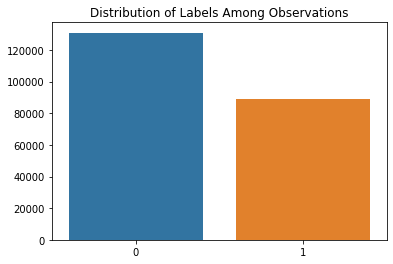

In [ ]:
import seaborn as sns
label_dist =train_labels['label'].value_counts()
label_dist.values
ax = sns.barplot(x=label_dist.index.tolist(), y=label_dist.values.tolist())
ax.set_title('Distribution of Labels Among Observations')
plt.show()

As it is observed from the bar plot above, there is a class imbalance in the training set. That is the number of cancer images are more than the number of non-cancer images.

The next plots show ten(10) random images from the training set with label 0.

In [ ]:
#seperating examples with label 0 and example with label 1
zeros = train_labels[train_labels.label=='0']
ones =  train_labels[train_labels.label=='1']

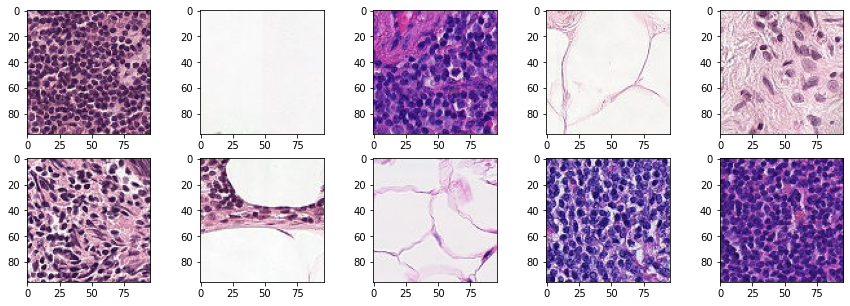

In [ ]:

random_indices = np.random.randint(0,zeros.shape[0],10)

fig, axes = plt.subplots(2,5, figsize = (15,5))
# figure(figsize=(40,30))

for number, idx in enumerate(random_indices):
     filename = zeros.iloc[idx, 0]
     image = plt.imread(train_path+'/'+ filename)
     axes[number//5,number%5].imshow(image)
 

The next plot show ten (10) random images from the training set with label 1.

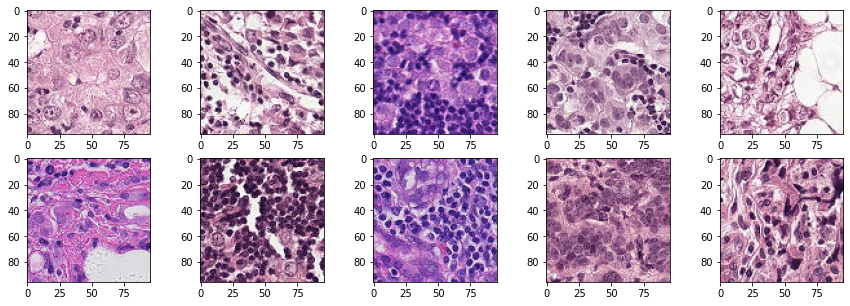

In [ ]:
random_indices = np.random.randint(0,ones.shape[0],10)

fig, axes = plt.subplots(2,5, figsize = (15,5))

for number, idx in enumerate(random_indices):
     filename = ones.iloc[idx, 0]
     image = plt.imread(train_path+'/'+ filename)
     axes[number//5,number%5].imshow(image)
 

## **Data Preprocessing and Plan of Analysis**

**Normalization:** To make pixel have values between 0 and 1, their values are divided by 255.

**Shuffling:** To make the learning algorithm independent of original order of training examples, they are shuffled randomly.

**Data Split** The training set is split into two parts. The bigger part (80% of whole labelled data) is used to train the deep learning algorithm and the smaller part (20% of whole labelled data) is used for hyperparameter tuning and model selection.

**Plan of Analysis based on EDA** As it was observed in the EDA part, the training set is imbalanced, meaning that there are more exmples with label 0 than those with label 1. This suggest that it would be a good idea to evaluate the output of the deep learning models not based on accuracy metric but based on the other metrics like area under Precision Recall curve.



## **Model Architecture**
This section describes the architecture used for the deep neural network models in this project . The architecture specifies the number of convolution and dense layers and the number of neuron in each layer. The type of activation function in each layer is also determined.

### **Model 1: The Basic Model**

**Description of Model 1**

The model one includes input layer followed by two convolutional layers, a max pooling layer and output layer as denoted below:

Input layer --> Convolution Layer 1  --> Convolutional Layer 2 --> Max Pooling Layer --> Dense Layer --> Output Layer

Both convolutional layers have  16 and 32 filters with size (3,3)

The convolutional layers have ReLU activation function. The output layer have sigmoid activation layer as this is a binary classification problem. The dense layer has 1 neuron.

**Why Choosing this Architecture?** 


This model is an intermediate model in terms of complexity. Not too simple as model one and not too complex as the next model. The model provides an intuition for the degree of complexity that  works best for the current volume of data.

In [ ]:
batch_size = 32
learning_rate = 0.0001
epoch = 10

In [ ]:

# Because the whole training data cannot be loaded into memory at once the following code uses ImageDataGenerator to create a python generator that feeds the 
# the deep learning model a batch of training examples each time.
datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
training = datagen.flow_from_dataframe(
    dataframe = train_labels,
    directory = train_path, 
    shuffle= True,
    x_col ='id', 
    y_col='label',
    subset ='training',
    batch_size = batch_size,
    target_size = (96,96),
    seed =123,
    class_mode = 'binary'
    )


validation =datagen.flow_from_dataframe(
    dataframe = train_labels,
    directory = train_path, 
    shuffle= True,
    x_col ='id', 
    y_col='label',
    subset ='validation',
    batch_size = batch_size,
    target_size = (96,96),
    seed =123,
    class_mode = 'binary'
    )

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [ ]:
model_1 = Sequential() # initializes a sequential API from Keras
model_1.add(Conv2D(filters = 16, kernel_size =(3,3), input_shape = ( 96,96,3),activation = 'relu')) # defines a convolutonal layer  with 16 filters and size (3,3)  and ReLU activation function
model_1.add(Conv2D(filters =32, kernel_size =(3,3),activation = 'relu')) # defines a convolutonal layer  with 32 filters and size (3,3)  and ReLU activation function
model_1.add(MaxPooling2D(pool_size=(2,2))) # defines a max pooling layer with size (2,2)
model_1.add(Flatten()) # flatten last created feature map
model_1.add(Dense(1,activation ='sigmoid' )) #defines a dense layer with one unit and sigmoid activation function

auc_roc= AUC(curve='ROC', name = 'AUC_ROC')
auc_pr = AUC(curve ='PR', name = 'AUC_PR')

model_1.compile(optimizer = Adam(learning_rate= learning_rate ), loss = 'binary_crossentropy', metrics =['accuracy',auc_roc,auc_pr])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 67712)             0         
                                                                 
 dense (Dense)               (None, 1)                 67713     
                                                                 
Total params: 72,801
Trainable params: 72,801
Non-trainable params: 0
____________________________________________________

In [ ]:
model_1_history = model_1.fit(training, epochs = epoch , validation_data = validation)

Epoch 1/10
5501/5501 [==============================] - 354s 63ms/step - loss: 0.4512 - accuracy: 0.7928 - AUC_ROC: 0.8636 - AUC_PR: 0.8123 - val_loss: 0.4351 - val_accuracy: 0.7997 - val_AUC_ROC: 0.8795 - val_AUC_PR: 0.8397
Epoch 2/10
5501/5501 [==============================] - 284s 52ms/step - loss: 0.4162 - accuracy: 0.8126 - AUC_ROC: 0.8851 - AUC_PR: 0.8468 - val_loss: 0.4028 - val_accuracy: 0.8213 - val_AUC_ROC: 0.8922 - val_AUC_PR: 0.8608
Epoch 3/10
5501/5501 [==============================] - 270s 49ms/step - loss: 0.3894 - accuracy: 0.8280 - AUC_ROC: 0.9003 - AUC_PR: 0.8686 - val_loss: 0.4078 - val_accuracy: 0.8212 - val_AUC_ROC: 0.9029 - val_AUC_PR: 0.8754
Epoch 4/10
5501/5501 [==============================] - 268s 49ms/step - loss: 0.3696 - accuracy: 0.8389 - AUC_ROC: 0.9109 - AUC_PR: 0.8823 - val_loss: 0.4199 - val_accuracy: 0.8097 - val_AUC_ROC: 0.9036 - val_AUC_PR: 0.8731
Epoch 5/10
5501/5501 [==============================] - 256s 47ms/step - loss: 0.3555 - accuracy: 0.

In [ ]:
# model_1.save('/content/drive/MyDrive/saved_models_Dec_2022/model1.h5')
# pickle.dump(model_1_history.history, open('/content/drive/MyDrive/saved_models_Dec_2022/model_1_history','wb'))

In [ ]:
model_1 = load_model('/content/drive/MyDrive/saved_models_Dec_2022/model1.h5')
model_1_hist = pickle.load(open('/content/drive/MyDrive/saved_models_Dec_2022/model_1_history','rb'))

### **Model 2: The Deeper Model**

**Description of Model 2**

The second model is slightly deeper than the previous model. Two extra hidden layers followed by a max pooling layer were added.  The architecture denoted below:

Input layer --> 

Concolutional Layer 1 --> Convolutional Layer 2 --> Max Pooling Layer 1--> 

Concolutional Layer 3 --> Convolutional Layer 4 --> Max Pooling Layer 2 --> 

Dense Layer --> 

Ouput Layer

The first two convolutional layers have 16 filters each with size (3,3). The third and fourth convolutional layers have 32 filters each with size (3,3). All the convolutional layers have ReLU activation functions. The output layer have sigmoid activation function. The loss function is binary cross entropy as this is the binary classification problem.Also, the dense layer has 1 neuron.


**Why Choosing this Architecture?** 


This model acts as simplest and baseline. The model helps understand how complex the final model should be.

In [ ]:
batch_size = 32
learning_rate = 0.0001
epoch = 10

In [ ]:
model_2 = Sequential() # initializes a sequential API from Keras
model_2.add(Conv2D(filters = 16, kernel_size =(3,3), input_shape = ( 96,96,3),activation = 'relu'))  # defines a convolutonal layer with 16 filters and size (3,3)  and ReLU activation function
model_2.add(Conv2D(filters = 16, kernel_size =(3,3),activation = 'relu'))  # defines a convolutonal layer with 16 filters and size (3,3)  and ReLU activation function
model_2.add(MaxPooling2D(pool_size=(2,2))) # defines a max pooling layer with size (2,2)

model_2.add(Conv2D(filters = 32, kernel_size =(3,3), input_shape = ( 96,96,3),activation = 'relu'))  # defines a convolutonal layer  with 32 filters and size (3,3)  and ReLU activation function
model_2.add(Conv2D(filters = 32, kernel_size =(3,3),activation = 'relu'))  # defines a convolutonal layer  with 32 filters and size (3,3)  and ReLU activation function
model_2.add(MaxPooling2D(pool_size=(2,2))) # defines a max pooling layer with size (2,2)

model_2.add(Flatten()) # flatten last created feature map
model_2.add(Dense(1,activation ='sigmoid' )) # defines a dense layer with one unit and sigmoid activation function


auc_roc= AUC(curve='ROC', name = 'AUC_ROC')
auc_pr = AUC(curve ='PR', name = 'AUC_PR')

model_2.compile(optimizer = Adam(learning_rate= learning_rate ), loss = 'binary_crossentropy', metrics =['accuracy',auc_roc,auc_pr])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 94, 94, 16)        448       
                                                                 
 conv2d_3 (Conv2D)           (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 46, 46, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 44, 44, 32)        4640      
                                                                 
 conv2d_5 (Conv2D)           (None, 42, 42, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 21, 21, 32)       0         
 2D)                                                  

In [ ]:
model_2_history = model_2.fit(training, epochs = epoch , validation_data = validation)

Epoch 1/10
5501/5501 [==============================] - 285s 51ms/step - loss: 0.4480 - accuracy: 0.7930 - AUC_ROC: 0.8655 - AUC_PR: 0.8172 - val_loss: 0.4079 - val_accuracy: 0.8190 - val_AUC_ROC: 0.8910 - val_AUC_PR: 0.8582
Epoch 2/10
5501/5501 [==============================] - 280s 51ms/step - loss: 0.3939 - accuracy: 0.8252 - AUC_ROC: 0.8974 - AUC_PR: 0.8665 - val_loss: 0.3724 - val_accuracy: 0.8388 - val_AUC_ROC: 0.9100 - val_AUC_PR: 0.8838
Epoch 3/10
5501/5501 [==============================] - 274s 50ms/step - loss: 0.3722 - accuracy: 0.8375 - AUC_ROC: 0.9095 - AUC_PR: 0.8817 - val_loss: 0.3574 - val_accuracy: 0.8459 - val_AUC_ROC: 0.9179 - val_AUC_PR: 0.8922
Epoch 4/10
5501/5501 [==============================] - 304s 55ms/step - loss: 0.3595 - accuracy: 0.8449 - AUC_ROC: 0.9165 - AUC_PR: 0.8902 - val_loss: 0.3521 - val_accuracy: 0.8492 - val_AUC_ROC: 0.9233 - val_AUC_PR: 0.9000
Epoch 5/10
5501/5501 [==============================] - 281s 51ms/step - loss: 0.3466 - accuracy: 0.

In [ ]:
# model_2.save('/content/drive/MyDrive/saved_models_Dec_2022/model2.h5')
# pickle.dump(model_2_history.history, open('/content/drive/MyDrive/saved_models_Dec_2022/model_2_history','wb'))

In [ ]:
model_2 = load_model('/content/drive/MyDrive/saved_models_Dec_2022/model2.h5')
model_2_hist = pickle.load(open('/content/drive/MyDrive/saved_models_Dec_2022/model_2_history','rb'))

### **Model 3: The Deepest Model**

**Description of Model 3**

The third and last model has 8 convolutional layers , 4 max pooling layer and 5 dropout . The architecture is denoted below:

Input Layer -->

Convolutional Layer 1 --> Convolutional Layer 2 --> Max Pooling Layer 1 --> Dropout  1 --> 


Convolutional Layer 3 --> Convolutional Layer 4 --> Max Pooling Layer 2 --> Dropout  2 -->

Convolutional Layer 5 --> Convolutional Layer 6 --> Max Pooling Layer 3 --> Dropout  3 -->


Convolutional Layer 7 --> Convolutional Layer 8 --> Max Pooling Layer 4 --> Dropout  4 -->

Dropout  5 --> Dense Layer -->

Ouput Layer


The convolutional layers 1 to 8  have 16, 16, 32, 32, 128, 128, 256, 256 filters respectively.

The size of each filter is (3,3) and the pooling size is (2,2)

The dense layer has 1 neuron.

The loss function is binary cross entropy. The activation function for hidden layers is ReLU and it is sigmoid for the output layer.

**Why Choosing this Model?** 

This model is the most complex model among the models tried so far. The model demands relatively large computational power compared to two previous models. This model is expected to perform best. However, It might be the case that the model overfit  and cannot acheive its goal. Therefore, the model should given a chance to see how it works with the given training data.


**Comparison of Multiple Architectures**

In terms of complexity or number of parameters models are compared as follows:

Model 3 > Model 1 > Model 2


In terms of computational intensity the models are compared as follows:

Model 3 > Model 1 > Model 2


In terms of model performance the models are compared as follows:

Model 3 > Model 2  > Model 1




#### **Hyperparameter Tuning**

As the deep learning models are usaully computationally intensive, it is not ferasible to conduct methods like Grid Search to acheive best hyperparemeters. Therefore, a trial and error strategy could be the choice.

In [ ]:
batch_size = 32
learning_rate = 0.0001
epoch = 10

In [ ]:
model_3 = Sequential() # initializes a sequential API from Keras
model_3.add(Conv2D(filters = 16, kernel_size =(3,3), input_shape = ( 96,96,3),activation = 'relu'))  # defines a convolutional layer  with 16 filters and size (3,3) and ReLU activation function
model_3.add(Conv2D(filters = 16, kernel_size =(3,3),activation = 'relu'))  #defines a convolutional layer with 16 filters and size (3,3) and ReLU activation function
model_3.add(MaxPooling2D(pool_size=(2,2)))  # defines a max pooling layer with size (2,2)
model_3.add(Dropout(0.1))  # defines a dropout with probability 0.1

model_3.add(Conv2D(filters = 32, kernel_size =(3,3), input_shape = ( 96,96,3),activation = 'relu'))  #defines a convolutional layer  with 32 filters and size (3,3) and ReLU activation function
model_3.add(Conv2D(filters = 32, kernel_size =(3,3),activation = 'relu'))  # defines a convolutional layer  with 32 filters and size (3,3) and ReLU activation function
model_3.add(MaxPooling2D(pool_size=(2,2)))  # defines a max pooling layer with size (2,2)
model_3.add(Dropout(0.1)) # defines a dropout with probability 0.1

model_3.add(Conv2D(filters = 128, kernel_size =(3,3), input_shape = ( 96,96,3),activation = 'relu'))  #defines a convolutional layer  with 128 filters and size (3,3) and ReLU activation function
model_3.add(Conv2D(filters = 128, kernel_size =(3,3),activation = 'relu')) #defines a convolutional layer  with 128 filters and size (3,3) and ReLU activation function
model_3.add(MaxPooling2D(pool_size=(2,2)))  # defines a max pooling layer with size (2,2)
model_3.add(Dropout(0.1))  # defines a dropout with probability 0.1

model_3.add(Conv2D(filters = 256, kernel_size =(3,3), input_shape = ( 96,96,3),activation = 'relu'))  #defines a convolutional layer  with 256 filters and size (3,3) and ReLU activation function
model_3.add(Conv2D(filters = 256, kernel_size =(3,3),activation = 'relu'))  #defines a convolutional layer  with 256 filters and size (3,3) and ReLU activation function
model_3.add(MaxPooling2D(pool_size=(2,2)))  # defines a max pooling layer with size (2,2)
model_3.add(Dropout(0.1))  # defines a dropout with probability 0.1

model_3.add(Flatten()) # flatten last created feature map
model_3.add(Dropout(0.1)) # defines a dropout with probability 0.1
model_3.add(Dense(1,activation ='sigmoid' )) # defines a dense layer with one unit and sigmoid activation function


auc_roc= AUC(curve='ROC', name = 'AUC_ROC')
auc_pr = AUC(curve ='PR', name = 'AUC_PR')



model_3.compile(optimizer = Adam(learning_rate= learning_rate ), loss = 'binary_crossentropy', metrics =['accuracy',auc_roc,auc_pr])
model_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 conv2d_23 (Conv2D)          (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 46, 46, 16)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 46, 46, 16)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 44, 44, 32)        4640      
                                                                 
 conv2d_25 (Conv2D)          (None, 42, 42, 32)        9248      
                                                      

In [ ]:
model_3_history = model_3.fit(training, epochs = epoch , validation_data = validation)

Epoch 1/10
5501/5501 [==============================] - 290s 53ms/step - loss: 0.4444 - accuracy: 0.7962 - AUC_ROC: 0.8672 - AUC_PR: 0.8246 - val_loss: 0.4442 - val_accuracy: 0.8001 - val_AUC_ROC: 0.9051 - val_AUC_PR: 0.8772
Epoch 2/10
5501/5501 [==============================] - 300s 54ms/step - loss: 0.3621 - accuracy: 0.8431 - AUC_ROC: 0.9140 - AUC_PR: 0.8885 - val_loss: 0.3438 - val_accuracy: 0.8487 - val_AUC_ROC: 0.9311 - val_AUC_PR: 0.9106
Epoch 3/10
5501/5501 [==============================] - 296s 54ms/step - loss: 0.3192 - accuracy: 0.8644 - AUC_ROC: 0.9338 - AUC_PR: 0.9142 - val_loss: 0.2990 - val_accuracy: 0.8746 - val_AUC_ROC: 0.9417 - val_AUC_PR: 0.9246
Epoch 4/10
5501/5501 [==============================] - 293s 53ms/step - loss: 0.2929 - accuracy: 0.8769 - AUC_ROC: 0.9442 - AUC_PR: 0.9281 - val_loss: 0.2666 - val_accuracy: 0.8890 - val_AUC_ROC: 0.9538 - val_AUC_PR: 0.9408
Epoch 5/10
5501/5501 [==============================] - 288s 52ms/step - loss: 0.2701 - accuracy: 0.

In [ ]:
# model_3.save('/content/drive/MyDrive/saved_models_Dec_2022/model3.h5')
# pickle.dump(model_3_history.history, open('/content/drive/MyDrive/saved_models_Dec_2022/model_3_history','wb'))

In [ ]:
model_3 = load_model('/content/drive/MyDrive/saved_models_Dec_2022/model3.h5')
model_3_hist = pickle.load(open('/content/drive/MyDrive/saved_models_Dec_2022/model_3_history','rb'))

In [ ]:
sample_submission = pd.read_csv(os.path.join(dataset_path,'sample_submission.csv'))
sample_submission['label'] = sample_submission['label'].astype('str')
sample_submission['id'] = sample_submission['id'].apply(lambda filename: filename + '.tif')

In [ ]:
sample_submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif,0
1,95596b92e5066c5c52466c90b69ff089b39f2737.tif,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif,0
3,2c35657e312966e9294eac6841726ff3a748febf.tif,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif,0


In [ ]:
datagen_test = ImageDataGenerator(rescale = 1./255)
test= datagen_test.flow_from_dataframe(
    dataframe = sample_submission,
    color_mode ='rgb',
    directory = test_path, 
    shuffle = False,
    x_col ='id', 
    batch_size = 32,
    target_size = (96,96),
    seed =123,
    class_mode = None
    )

Found 57458 validated image filenames.


In [ ]:
y_pred = model_3.predict(test)

1796/1796 [==============================] - 276s 153ms/step


In [ ]:
sample_submission['id']

0        0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5
1        95596b92e5066c5c52466c90b69ff089b39f2737
2        248e6738860e2ebcf6258cdc1f32f299e0c76914
3        2c35657e312966e9294eac6841726ff3a748febf
4        145782eb7caa1c516acbe2eda34d9a3f31c41fd6
                           ...                   
57453    061847314ded6f81e1cd670748bfa2003442c9c7
57454    6f3977130212641fd5808210015a609c658dcbff
57455    46935f247278539eca74b54d07d666efb528a753
57456    a09bcae08a82120183352e0e869181b2911d3dc1
57457    d29233dc0b90c2e1a8fcedbc3e1234c3d4dbd55b
Name: id, Length: 57458, dtype: object

In [ ]:

sample_submission['label']= y_pred
sample_submission['id'] = sample_submission['id'].apply(lambda filename: filename.split('.')[0])
sample_submission.head()
sample_submission.to_csv("/content/drive/MyDrive/saved_models_Dec_2022/submission.csv", index=False)

## **Results and Analysis**

This section provides some result and analysis based upon the experiment conducted in the previous section.

The performance of three models are measured based on the area under the precision recall curve.


### **Visaulizations**

Below are some plots that depcits the performance of the three models based on the area under the curve of precision and recall.

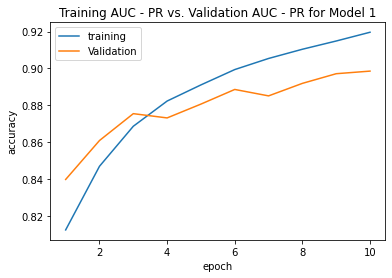

In [ ]:
# The following script plots the value for area under the  curve of precision recall for both training and validation set for model 1
sns.lineplot(x= range(1,11) ,y= model_1_hist['AUC_PR'],label = 'training') 
ax = sns.lineplot(x= range(1,11) ,y= model_1_hist['val_AUC_PR'],label ='Validation')
ax.set(xlabel='epoch', ylabel ='accuracy', title = 'Training AUC - PR vs. Validation AUC - PR for Model 1')

plt.show()

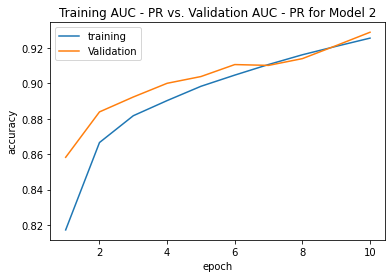

In [ ]:
# The following script plots the value for area under the  curve of precision recall for both training and validation set for model 2
sns.lineplot(x= range(1,11) ,y= model_2_hist['AUC_PR'],label = 'training')
ax = sns.lineplot(x= range(1,11) ,y= model_2_hist['val_AUC_PR'],label ='Validation')
ax.set(xlabel='epoch', ylabel ='accuracy', title = 'Training AUC - PR vs. Validation AUC - PR for Model 2')

plt.show()

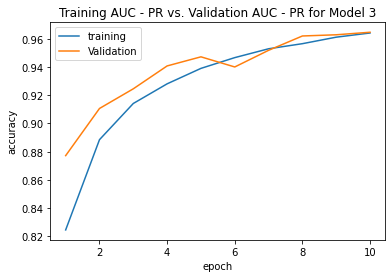

In [ ]:
# The following script plots the value for area under the curve of precision recall for both training and validation set for model 3
sns.lineplot(x= range(1,11) ,y= model_3_hist['AUC_PR'],label = 'training')
ax = sns.lineplot(x= range(1,11) ,y= model_3_hist['val_AUC_PR'],label ='Validation')
ax.set(xlabel='epoch', ylabel ='accuracy', title = 'Training AUC - PR vs. Validation AUC - PR for Model 3')

plt.show()


**Reasoning for the Best Performing Model**  As it can be observed from the above plots, the model 3 performs best in terms of AUC - PR for the validation set. This is because of to the high complexity of the model 3 which enables it to better extract the features.

**Summary for Hyperparameter Tuning.** In short, the hyperparemeter tuning for the models should be performed based on the expert suggestion or trial and error.

**Troubleshooting Procedure** Further improvement on the AUC - PR could be possible by adding extra layers to the model 3 and increasing its complexity. Also, running model 3 for more epochs can result in higher performance.


## **Conclusion**

**Results**  The models experimented in this project were evaluated based upon the area under the precision recall curve for the validation set. The results show that model 3 which is the most complex model outperforms other models

**Discussion and Takeaways** It can be concluded that when working with the kind of unstraucted data like the data in this project, probably the more complex model can perform better if the overfitting can be controlled. However, increasing the complexity comes at the cost of needing computational resources need which is not always easily available.

**Why other Models did not Perfrom as Good as Model 3?**

Because large volume of data  are involved in this projects, probably the other models have not suffiecient complexity to cope with this amount of data.

**Suggestion for the Future Work** future work for improiving the current project could be taking advantage of more computational resource to develop a even stronger model with higher number of layers.